# Elife Paper 
When using these notebooks for the first time, make sure the `load` parameter is False and `save` parameter is True. This will simulate and save the class including its data locally. While running it next time, and all consecutive times, make sure 'load' parameter is True. This will load the saved class locally saving essential runtime. 
## Figure 4: Need for Nightly jumps 
1. With jumps - C, D, E
2. Without jumps - A, B
3. F: Comparing their success
### Reward Landscapes

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import json 
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN

In [2]:
# load parameters from json file
params_path = "params_4_jumps.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 40
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING)                  
print(f'Random seed is {RANDOM_SEED}')

1
Random seed is 40


In [3]:
# Config
# 1 to load model
# 1 to save model
load = 1
save = 0
model_version = "model_4_40"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


Model 'model_4_40' loaded successfully!


### All functions for figures. Labelled below.

### A, C

In [4]:
def plot_spec_avg_traj(syll, day_i, day_f, N_i, N_f, steepness = 5.0):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = color_contour_bckg  # Match the colormap style from plot_landscape
    levels_ = 50

    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        if if_contour:
            axs.contour(X, Y, Z, levels=15, colors='k', linewidths=1, alpha=0.9)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        if if_contour:
            axs.contour(Z.T, levels=20, extent=[-1, 1, -1, 1], colors='k', linewidths=1, alpha=0.5)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-1, 0, 1], [-1, 0, 1])
        axs.set_yticks([-1, 0, 1], [-1, 0, 1])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Plot background landscape
    if obj.LANDSCAPE == 0:
        plot_artificial()
    else:
        plot_syrinx()

    # Plot agent trajectory
    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    # xtraj_smooth = running_mean(np.array(x_traj), N=every_nth_point)
    # ytraj_smooth = running_mean(np.array(y_traj), N=every_nth_point)
    xtraj_smooth = running_mean_dynamic(np.array(x_traj), N_i=N_i, N_f=N_f, steepness=steepness)
    ytraj_smooth = running_mean_dynamic(np.array(y_traj), N_i=N_i, N_f=N_f, steepness=steepness)
    axs.plot(
        xtraj_smooth[day_i * TRIALS: day_f * TRIALS], #[::every_nth_point],
        ytraj_smooth[day_i * TRIALS: day_f * TRIALS],#[::every_nth_point],
        color = color_motor, label='Agent Trajectory', alpha=0.5, linewidth=1, marker='.', markersize=1
    )

    axs.scatter(x_traj[0], y_traj[0],
                s=200, c='yellow', edgecolors='black',
                marker='o', linewidths=2, zorder=3, label='Starting Point')
    axs.text(x_traj[0] + 0.1, y_traj[0] + 0.1, 'Start', fontsize=15, ha='center', va='bottom')
    axs.text(x_traj[-1] + 0.1, y_traj[-1] + 0.1, 'End', fontsize=15, ha='center', va='bottom')
    axs.scatter(x_traj[-1], y_traj[-1],
                s=200, c='red', edgecolors='black',
                marker='o', linewidths=2, zorder=4, label='Ending Point')

    # Labels
    axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    # axs.set_ylabel(r'$P_{\alpha}$ (Pressure)', fontsize=22)
    # axs.set_xlabel(r'$P_{\beta}$ (Tension)', fontsize=22)
    axs.tick_params(labelsize=16)
    # axs.legend()
    plt.tight_layout()
    plt.show()


### B, D

In [5]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

def plot_reward_with_zoom(obj, main_first_day=0, main_last_day=60,
                          zoom1_first_day=5, zoom1_last_day=7,
                          zoom2_first_day=20, zoom2_last_day=22,
                          syll=0, if_inset = True):

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    array = obj.rewards[:, :, syll].reshape(DAYS * N_DAILY_MOTIFS)

    # Main plot segment
    start_main = main_first_day * N_DAILY_MOTIFS
    end_main = main_last_day * N_DAILY_MOTIFS
    segment_main = array[start_main:end_main]
    every_nth = 20

    # Plot raw reward (main)
    ax.plot(np.arange(start_main, end_main, every_nth), segment_main[::every_nth],
            marker='.', linestyle='None', alpha=0.5, markersize=1, color=color_reward)

    # Plot running mean (main)
    smooth_main = running_mean(segment_main, 300)
    smooth_x_main = np.arange(start_main, end_main)
    ax.plot(smooth_x_main, smooth_main, lw=1.5, alpha=0.9, color=color_reward)

    ax.set_xlabel('Days', fontsize=18)
    ax.set_ylabel('Performance metric', fontsize=18)
    ax.set_ylim(0, 1)
    ax.tick_params(labelsize=12)
    ax.set_yticks([0, 1])
    ax.set_xticks(np.arange(start_main, end_main + 1, 10 * N_DAILY_MOTIFS),
                  40 + np.arange(main_first_day, main_last_day + 1, 10))
    ax.set_xlim(start_main, end_main)
    ax.axvline(x=BG_INTACT_DAYS * TRIALS, ymin=0, ymax=1.2,
               linestyle=':', color='grey', lw=1, label='Lesion')
    # Vertical lines for every day
    for day in range(main_first_day, main_last_day + 1):
        ax.axvline(x=day * N_DAILY_MOTIFS, linestyle=':', color='grey', lw=0.5)
    if if_inset:    # === Zoom Inset 1 === #
        axins1 = inset_axes(ax, width="15%", height="60%",
                                bbox_to_anchor=(0.2, 0.65, 1, 1),
                                bbox_transform=ax.transAxes, loc='upper left',
                                borderpad=0)

        start1 = zoom1_first_day * N_DAILY_MOTIFS
        end1 = zoom1_last_day * N_DAILY_MOTIFS
        seg1 = array[start1:end1]

        axins1.plot(np.arange(start1, end1), seg1, marker='.', linestyle='None',
                        alpha=0.2, markersize=2, color=color_reward)
        smooth1 = running_mean(seg1, 100)
        axins1.plot(np.arange(start1, end1)[::10], smooth1[::10], lw=1.5, alpha=0.9, color=color_reward)
        axins1.set_xlim(start1, end1)
        axins1.set_ylim(0.0, 1.0)
        axins1.set_xticks([])
        axins1.set_yticks([])
        for day in range(zoom1_first_day, zoom1_last_day + 1):
            axins1.axvline(x = day*TRIALS, ymin=0, ymax=1.2, color = 'black', lw=0.5)

        # === Zoom Inset 2 === #
        axins2 = inset_axes(ax, width="15%", height="60%",
                                bbox_to_anchor=(0.6, 0.65, 1, 1),
                                bbox_transform=ax.transAxes, loc='upper left',
                                borderpad=0)

        start2 = zoom2_first_day * N_DAILY_MOTIFS
        end2 = zoom2_last_day * N_DAILY_MOTIFS
        seg2 = array[start2:end2]

        axins2.plot(np.arange(start2, end2), seg2, marker='.', linestyle='None',
                        alpha=0.2, markersize=2, color=color_reward)
        smooth2 = running_mean(seg2, 100)
        axins2.plot(np.arange(start2, end2)[::10], smooth2[::10], lw=1.5, alpha=0.9, color=color_reward)
        axins2.set_xlim(start2, end2)
        axins2.set_ylim(0.0, 1.0)
        axins2.set_xticks([])
        axins2.set_yticks([])
        for day in range(zoom2_first_day, zoom2_last_day + 1):
            axins2.axvline(x = day*TRIALS, ymin=0, ymax=1.2, color = 'black', lw=0.5)

        # Indicate zoom regions
        ax.indicate_inset_zoom(axins1, edgecolor="black", alpha=1, lw=0.5, )
        ax.indicate_inset_zoom(axins2, edgecolor="black", alpha=1, lw=0.5)

    plt.tight_layout()
    plt.show()




### E

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
def plot_BG_volatility(obj, zoom_start=200, zoom_end=400):
    figure, ax1 = plt.subplots(1, figsize=(10, 4))

    # Main plot
    bg_trace = running_mean(obj.bg_out[:,:,1].reshape((DAYS)*N_DAILY_MOTIFS),30)
    ax1.plot(bg_trace, color=color_bg, alpha=0.8, linewidth=2)
    # ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)     
    [ax1.axvline(x=k, linestyle='-', color='black', alpha=0.1) 
     for k in range(0, DAYS*N_DAILY_MOTIFS, N_DAILY_MOTIFS)]    

    # Axis settings
    ax1.set_xlabel('Days', fontsize=20)
    ax1.set_ylabel('HVC-BG\nweights', fontsize=20)
    ax1.set_ylim(-1, 1)
    ax1.set_yticks([-1, 0, 1])
    ax1.tick_params(labelsize=15)
    ax1.set_xlim(-N_DAILY_MOTIFS, DAYS*N_DAILY_MOTIFS)   
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_bounds(0, DAYS*N_DAILY_MOTIFS)
    plt.xticks(range(0, N_DAILY_MOTIFS*(DAYS+1), 20*N_DAILY_MOTIFS), 
               np.arange(40, 40+DAYS+1, 20))    

    # === Inset Zoom ===
    zoom_ax = inset_axes(ax1, width="10%", height="40%", loc="upper right", )
    zoom_ax.plot(bg_trace, color=color_bg, linewidth=1.5)

    # Zoomed region limits
    zoom_ax.set_xlim(zoom_start, zoom_end)
    zoom_ax.set_ylim(-1, 1)
    zoom_ax.set_yticks([-1, 0, 1])
    zoom_ax.set_xticks([zoom_start, zoom_end-1])
    zoom_ax.set_xticklabels([f"Day {zoom_start//TRIALS + 40}", f"Day {zoom_end//TRIALS + 40}"])
    zoom_ax.tick_params(labelsize=10)
    for day in range(zoom_start//TRIALS, zoom_end//TRIALS + 1):
        zoom_ax.axvline(x = day*TRIALS, ymin=-1, ymax=1, color = 'black', lw=0.5)

    # Add rectangle + connectors
    mark_inset(ax1, zoom_ax, loc1=2, loc2=4, fc="none", ec="black", lw=1)

    plt.tight_layout()
    plt.show()



### With Night jumps

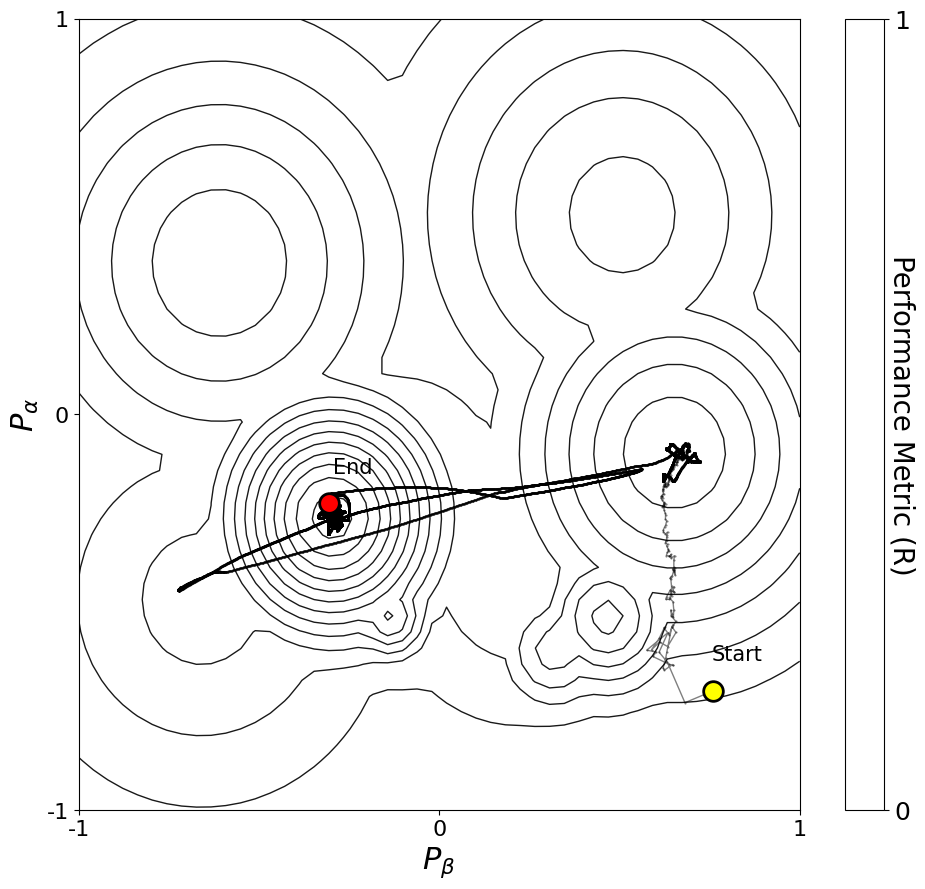

/tmp/ipykernel_3075074/2059905999.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


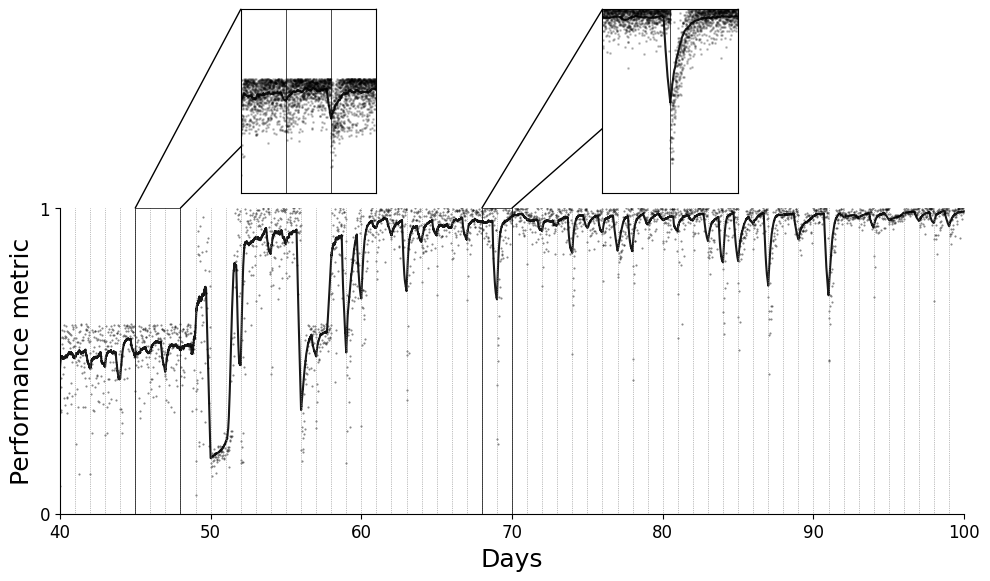

In [7]:
plot_spec_avg_traj(syll = 2, day_i = 0, day_f = 60, N_i = 1, N_f = 2000, steepness = 20)
plot_reward_with_zoom(obj, main_first_day=0, main_last_day=60, zoom1_first_day=5, zoom1_last_day=8, zoom2_first_day=28, zoom2_last_day=30, syll=2, if_inset = True)

/tmp/ipykernel_3075074/106595846.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


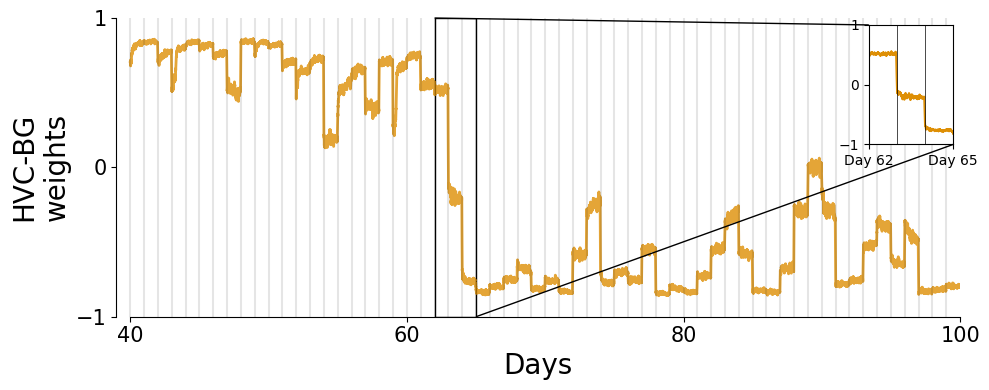

In [8]:
plot_BG_volatility(obj, zoom_start=22000, zoom_end=25000)


### Without nightly jumps

In [9]:
# load parameters from json file
params_path = "params_4_nojumps.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 40
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING)                  
print(f'Random seed is {RANDOM_SEED}')

# Config
# 1 to load model
# 1 to save model
load = 1
save = 0
model_version = "model_4_40_nojump"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


0
Random seed is 40
Model 'model_4_40_nojump' loaded successfully!


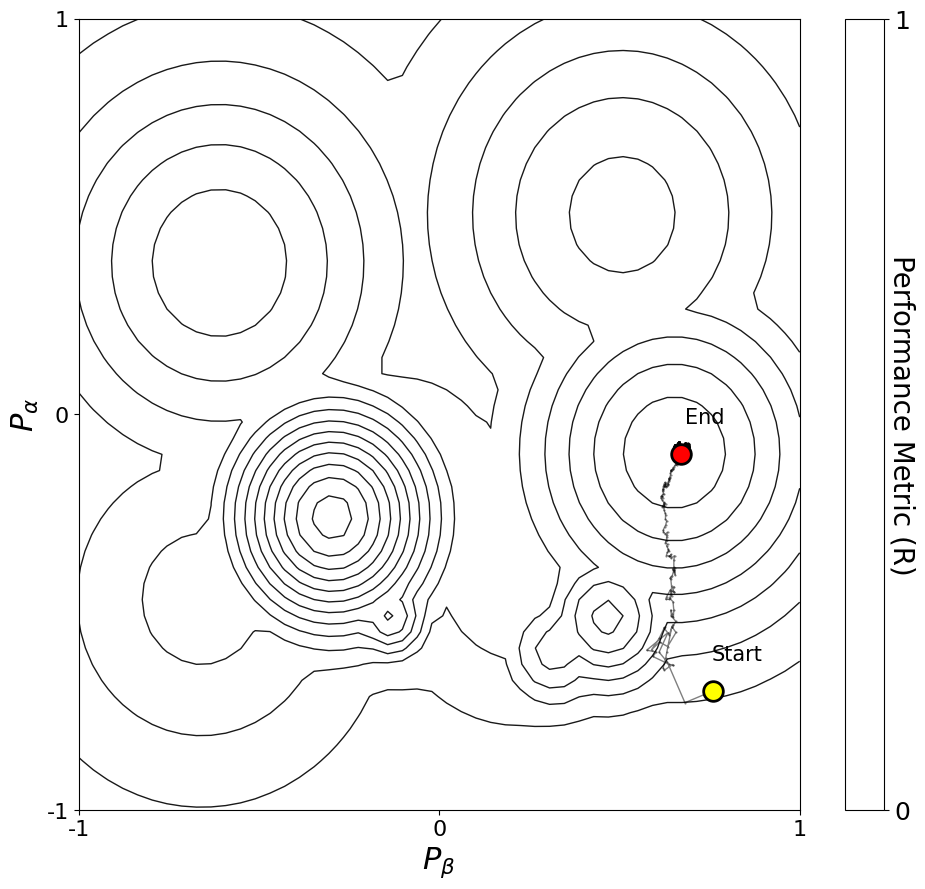

/tmp/ipykernel_3075074/2059905999.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


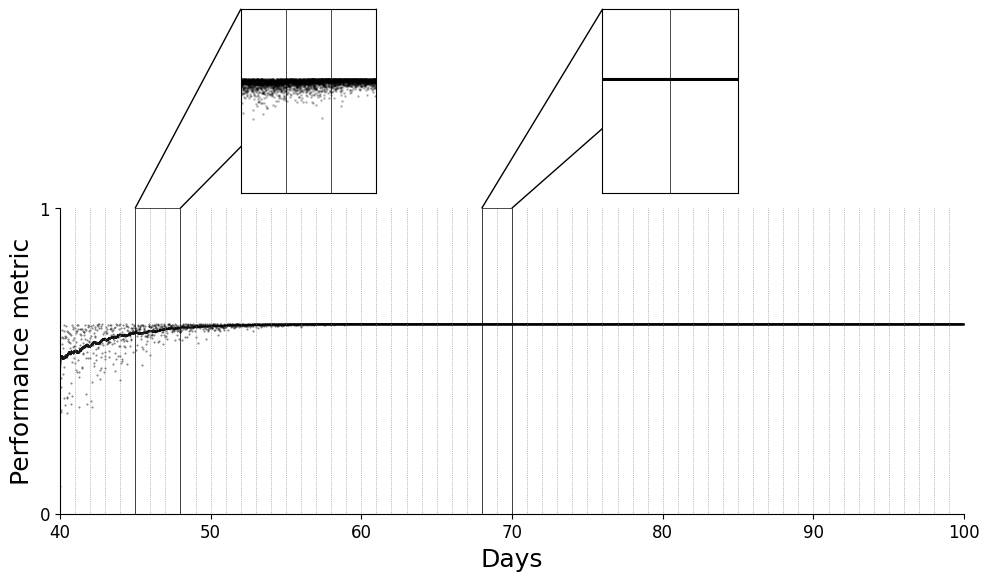

In [10]:
plot_spec_avg_traj(syll = 2, day_i = 0, day_f = 60, N_i = 1, N_f = 2000, steepness = 20)
plot_reward_with_zoom(obj, main_first_day=0, main_last_day=60, zoom1_first_day=5, zoom1_last_day=8, zoom2_first_day=28, zoom2_last_day=30, syll=2, if_inset = True)

/tmp/ipykernel_3075074/106595846.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


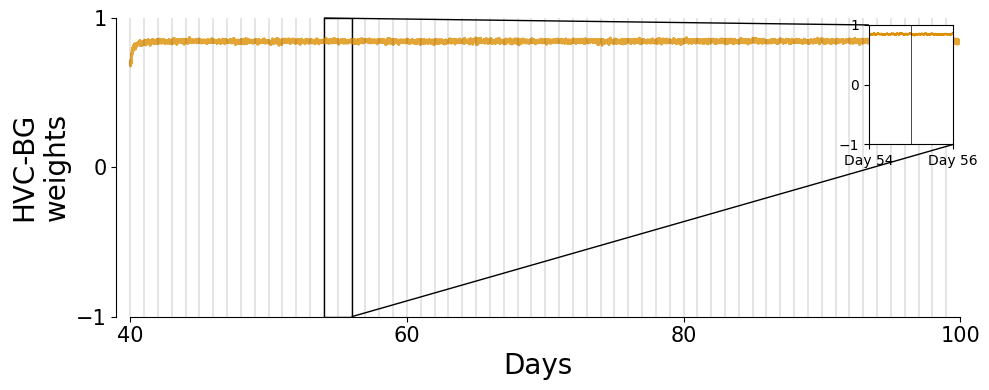

In [11]:
plot_BG_volatility(obj, zoom_start=14000, zoom_end=16000)

### For comparision of performance visit `../Robustness` directory